ViT가 요구하는 입력 형태 만들기\

이미지 로딩 (로컬 / URL)
PIL ↔ NumPy ↔ Tensor 변환
Resize, Normalize 수행
ViT 입력 규격 맞추기
이 파일의 본질

"ViT에게 먹일 수 있는 정확한 입력 데이터를 만드는 과정"

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, requests
from io import  BytesIO
from typing import List

In [3]:
def download_sample_images(save_dir:str) -> List:
    '''샘플 이미지 다운로드'''

    sample_images = {
        'cat.jpg': 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg',
        'dog.jpg': 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/YellowLabradorLooking_new.jpg/1200px-YellowLabradorLooking_new.jpg',
        'bird.jpg': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Eopsaltria_australis_-_Mogo_Campground.jpg/1200px-Eopsaltria_australis_-_Mogo_Campground.jpg',
    }
    downloaded_images = []
    os.makedirs(save_dir,exist_ok = True)
    for filename, url in sample_images.items():
        filepath = os.path.join(save_dir,filename)
        if os.path.exists(filepath):
            print(f' 이미 존재 : {filepath}')
            downloaded_images.append(filepath)
            continue
        try:
            print(f'다운로드 : {filename}')
            response = requests.get(url)
            response.raise_for_status()
            Image.open(BytesIO(response.content))
            image = Image.convert('RGB')
            image.save(filename)
            print(f'저장완료 : {filepath}')
            downloaded_images.append(filepath)
        except Exception as e:
            print(f'다운로드 실패: {e}')

    return downloaded_images

download_sample_images('./download_img')
    

 이미 존재 : ./download_img\cat.jpg
 이미 존재 : ./download_img\dog.jpg
 이미 존재 : ./download_img\bird.jpg


['./download_img\\cat.jpg',
 './download_img\\dog.jpg',
 './download_img\\bird.jpg']

In [4]:
# 기본이미지 로드
def basic_image_loading(image_path):
    '''기본 이미지 로딩 방법'''
    img = Image.open(image_path)
    print(f'[이미지 정보]')
    print(f'이미지 모드: {img.mode}')
    print(f'이미지 크기: {img.size}')

    # numpy 배열로 변환
    img_array = np.array(img)
    print(f'[넘파일 배열 변환]')
    print(f'배열 사이즈: {img_array.shape}')    # (H, W, C)
    print(f'이미지 크기: {img_array.dtype}')
    print(f'값 범위: {img_array.min()}~ {img_array.max()}')

    return img

In [5]:
# vit 표준 전처리
def vit_standard_preprocessing(img):
    '''vit 표준 전처리 파이프라인'''
    IMAGE_SIZE = 224
    MEAN = [0.5, 0.5, 0.5]  # ImageNet 평균 / 3개인 이유는 R,G,B 각 채널의 값
    STD = [0.2, 0.2, 0.2]   # ImageNet 표준편차

    # 전처리 파이프라인
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])
    print(f'[전처리 결과]')
    print(f'원본이미지 크기: {img.size}')
    img_tensor = preprocess(img)
    print(f'전처리 후 크기 : {img_tensor.shape}')
    print(f'전처리 후 값 범위 : {img_tensor.min()}~ {img_tensor.max()}')

    # 배치 차원 추가
    img_batch = img_tensor.unsqueeze(0)
    print(f' 배치처리 후 크기 : {img_batch.shape}')

    return img_tensor, preprocess


In [6]:
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# 학습용 데이터 증강

def training_augmentation(img):
    """학습 시 사용하는 데이터 증강"""

    
    # 학습용 증강 파이프라인
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # 랜덤 크롭
        transforms.RandomHorizontalFlip(p=0.5),                      # 좌우 반전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 색상 변형
        transforms.RandomRotation(degrees=15),                       # 회전
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
    
    # 평가용 파이프라인 (증강 없음)
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
    
    print(f"\n[학습용 증강 기법]")
    print(f"  1. RandomResizedCrop: 랜덤 위치/크기로 자르기")
    print(f"  2. RandomHorizontalFlip: 50% 확률로 좌우 반전")
    print(f"  3. ColorJitter: 밝기, 대비, 채도 변형")
    print(f"  4. RandomRotation: +-15도 회전")
    
    # 같은 이미지에 여러 번 증강 적용
    print(f"\n[동일 이미지에 증강 적용 예시]")
    augmented_images = []
    for i in range(4):
        aug_img = train_transform(img)
        augmented_images.append(aug_img)
        print(f"  증강 {i+1}: shape={aug_img.shape}, "
              f"min={aug_img.min():.3f}, max={aug_img.max():.3f}")
    
    return train_transform, val_transform, augmented_images

 이미 존재 : ./download_img\cat.jpg
 이미 존재 : ./download_img\dog.jpg
 이미 존재 : ./download_img\bird.jpg
[이미지 정보]
이미지 모드: RGB
이미지 크기: (1200, 1198)
[넘파일 배열 변환]
배열 사이즈: (1198, 1200, 3)
이미지 크기: uint8
값 범위: 0~ 255
[전처리 결과]
원본이미지 크기: (1200, 1198)
전처리 후 크기 : torch.Size([3, 224, 224])
전처리 후 값 범위 : -2.5~ 2.5
 배치처리 후 크기 : torch.Size([1, 3, 224, 224])

[학습용 증강 기법]
  1. RandomResizedCrop: 랜덤 위치/크기로 자르기
  2. RandomHorizontalFlip: 50% 확률로 좌우 반전
  3. ColorJitter: 밝기, 대비, 채도 변형
  4. RandomRotation: +-15도 회전

[동일 이미지에 증강 적용 예시]
  증강 1: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.187
  증강 2: shape=torch.Size([3, 224, 224]), min=-2.118, max=1.891
  증강 3: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.623
  증강 4: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.413


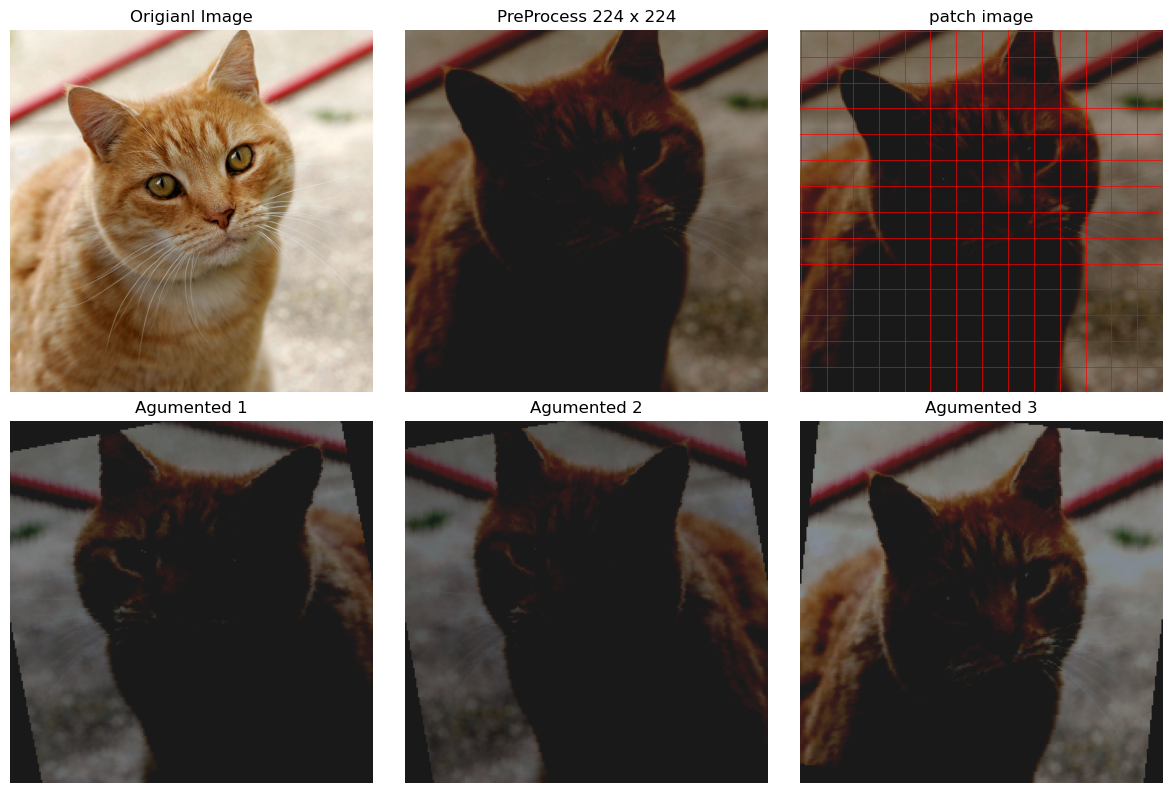

[이미지 정보]
이미지 모드: RGB
이미지 크기: (1200, 989)
[넘파일 배열 변환]
배열 사이즈: (989, 1200, 3)
이미지 크기: uint8
값 범위: 0~ 255
[전처리 결과]
원본이미지 크기: (1200, 989)
전처리 후 크기 : torch.Size([3, 224, 224])
전처리 후 값 범위 : -2.441176414489746~ 2.5
 배치처리 후 크기 : torch.Size([1, 3, 224, 224])

[학습용 증강 기법]
  1. RandomResizedCrop: 랜덤 위치/크기로 자르기
  2. RandomHorizontalFlip: 50% 확률로 좌우 반전
  3. ColorJitter: 밝기, 대비, 채도 변형
  4. RandomRotation: +-15도 회전

[동일 이미지에 증강 적용 예시]
  증강 1: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.483
  증강 2: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.640
  증강 3: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.640
  증강 4: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.135


<Figure size 640x480 with 0 Axes>

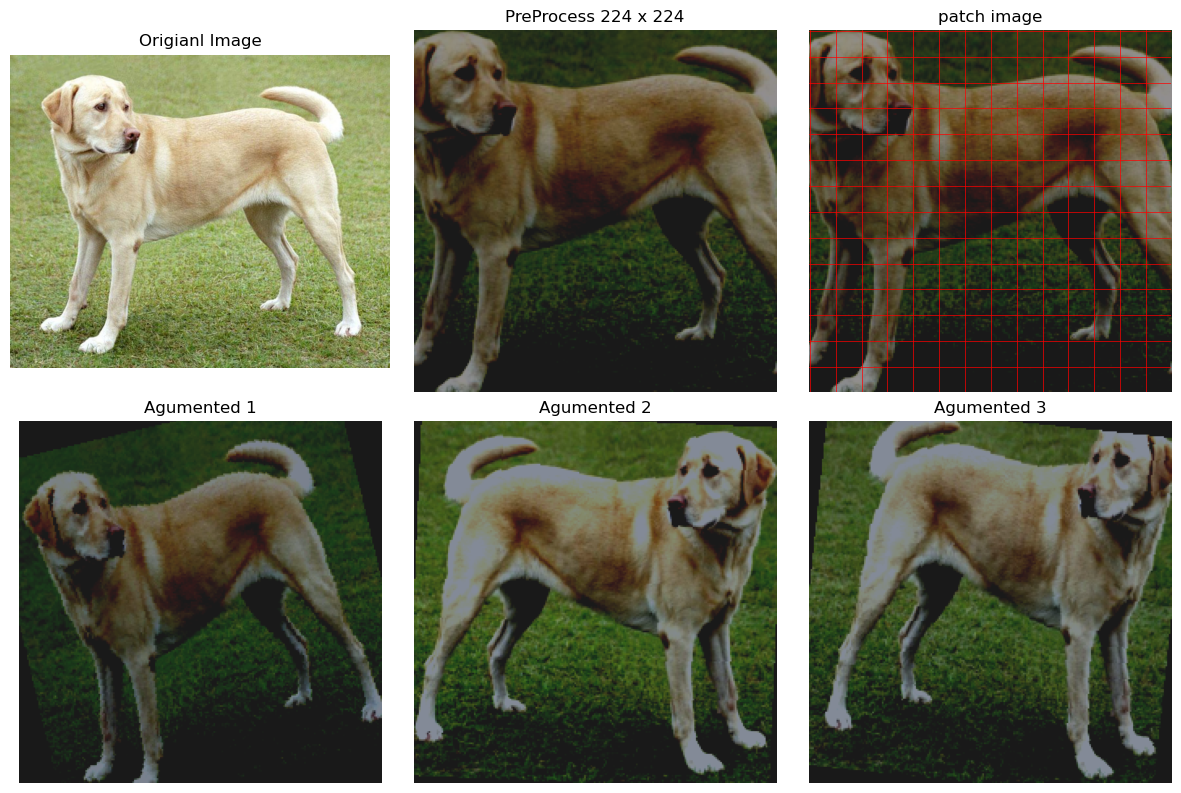

[이미지 정보]
이미지 모드: RGB
이미지 크기: (1200, 800)
[넘파일 배열 변환]
배열 사이즈: (800, 1200, 3)
이미지 크기: uint8
값 범위: 0~ 255
[전처리 결과]
원본이미지 크기: (1200, 800)
전처리 후 크기 : torch.Size([3, 224, 224])
전처리 후 값 범위 : -2.441176414489746~ 2.3235294818878174
 배치처리 후 크기 : torch.Size([1, 3, 224, 224])

[학습용 증강 기법]
  1. RandomResizedCrop: 랜덤 위치/크기로 자르기
  2. RandomHorizontalFlip: 50% 확률로 좌우 반전
  3. ColorJitter: 밝기, 대비, 채도 변형
  4. RandomRotation: +-15도 회전

[동일 이미지에 증강 적용 예시]
  증강 1: shape=torch.Size([3, 224, 224]), min=-2.118, max=1.925
  증강 2: shape=torch.Size([3, 224, 224]), min=-2.118, max=1.960
  증강 3: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.640
  증강 4: shape=torch.Size([3, 224, 224]), min=-2.118, max=2.588


<Figure size 640x480 with 0 Axes>

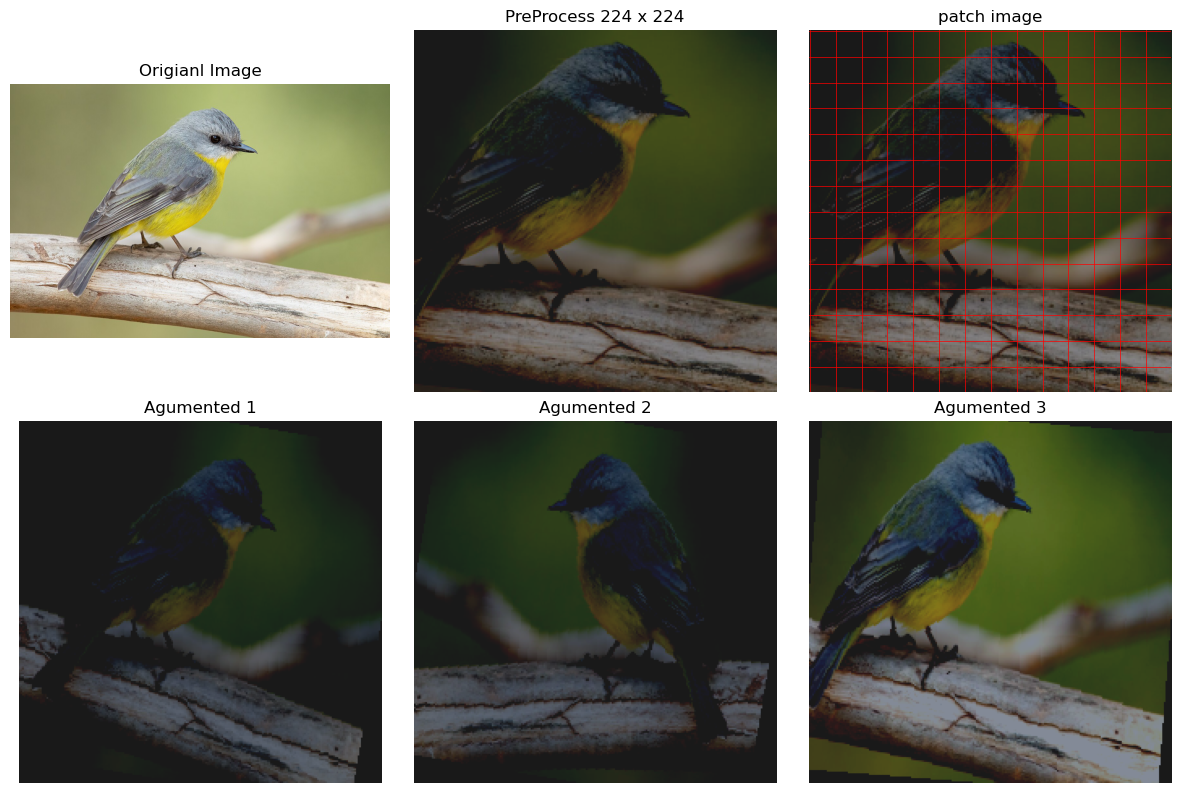

<Figure size 640x480 with 0 Axes>

In [17]:
# 전처리 시각화
def visualize_preprocess(img, img_tensor, augmented_images):
    '''전처리과정 시각화'''
    def denormalize(tensor, mean = MEAN, std= STD):
        '''정규화 역변환'''
        tensor = tensor.clone()
        for t,m,s in zip(tensor,mean,std):
            t.mul_(s).add(m)
        return torch.clamp(tensor,0.1)
    fig, axes = plt.subplots(2,3, figsize = (12,8))
    # 원본 이미지
    axes[0,0].imshow(img)
    axes[0,0].set_title('Origianl Image')
    axes[0,0].axis('off')

    # 전처리된 이미지
    img_display =  denormalize(img_tensor)
    axes[0,1].imshow(img_display.permute(1,2,0).numpy())
    axes[0,1].set_title('PreProcess 224 x 224')
    axes[0,1].axis('off')


    # 패치 분할 시각화
    patch_size = 16
    img_np=img_display.permute(1,2,0).numpy()
    axes[0,2].imshow(img_np)
    # 그리드 그리기 - 실제 패치로 임베딩한 공간정보가 아니라, vit가 이미지를 공간 단위로 나누어 본다
    for i in range(0,224,patch_size):
        axes[0,2].axhline(y=i, color='red',linewidth=0.5)
        axes[0,2].axvline(x=i, color='red',linewidth=0.5)
    axes[0,2].set_title('patch image')
    axes[0,2].axis('off')

    # 증강된 이미지들
    for i, aug_img in enumerate(augmented_images[:3]):
        aug_display = denormalize(aug_img)
        axes[1, i].imshow(aug_display.permute(1,2,0).numpy())
        axes[1, i].set_title(f'Agumented {i+1}')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()
    # 저장
    plt.savefig('02.vit.preprocess.png', bbox_inches='tight')

if __name__ == '__main__':
    os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
    sample_images = download_sample_images('./download_img')
    for img in sample_images:
        img = basic_image_loading(img)
        img_tensor, preprocess = vit_standard_preprocessing(img)
        train_transform, val_transform, augmented_images = training_augmentation(img)
        visualize_preprocess(img,img_tensor,augmented_images)